In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as tfs
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

In [2]:
transformations = tfs.Compose([tfs.ToTensor()
                               ])
train_data = MNIST('./', train=True,  transform=transformations, download=True) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 100
train_data_loader = DataLoader(train_data, batch_size=batch_size)

In [4]:
class RBM():
    def __init__(self, num_visible_units, num_hidden_units, cd_steps, lr):
      super().__init__() 
      self.num_visible_units = num_visible_units
      self.num_hidden_units = num_hidden_units
      self.cd_steps = cd_steps
      self.lr = lr
      self.weight_matrix = torch.empty((num_hidden_units, num_visible_units)).normal_(mean=0.,std=0.01).to(DEVICE)
      self.bias_visible = torch.ones(1, num_visible_units).to(DEVICE)
      self.bias_hidden = torch.zeros(1, num_hidden_units).to(DEVICE)

    def probabilities_hidden_units(self, vec_visible):
      # calculate P(h=1|v)=sigma(b+v*w)
      unbiased = torch.mm(vec_visible, self.weight_matrix.t())
      p_h_v = torch.sigmoid(self.bias_hidden.expand_as(unbiased) + unbiased) 
      return p_h_v, torch.bernoulli(p_h_v) 

    def probabilities_visible_units(self, vec_hidden):
      # calculate P(v=1|h)=sigma(a+w*h)
      unbiased = torch.mm(vec_hidden, self.weight_matrix)
      p_v_h = torch.sigmoid(self.bias_visible.expand_as(unbiased) + unbiased) 
      return p_v_h, torch.bernoulli(p_v_h)

    def cd_k(self, vec_input):
      v0 = vec_input
      #conditional probability of hidden units
      h0_prob, _ = self.probabilities_hidden_units(v0)
      #positive phase samples
      posprods = torch.mm(h0_prob.t(), v0)
      posvisact = torch.sum(v0, dim=0)
      poshidact = torch.sum(h0_prob, dim=0)      

      #negative phase 
      vk = v0

      for _ in range(self.cd_steps):
        _, hk = self.probabilities_hidden_units(vk)
        _, vk = self.probabilities_visible_units(hk)
       

      hk_prob, _ = self.probabilities_hidden_units(vk)

      negprods = torch.mm(hk_prob.t(), vk)
      negvisact = torch.sum(vk, dim=0)
      neghidact = torch.sum(hk_prob, dim=0)

      #updating learning parameters
      self.weight_matrix += self.lr * (posprods - negprods)
      self.bias_visible += self.lr * (posvisact - negvisact)
      self.bias_hidden += self.lr * (poshidact - neghidact)

      #error of the reconstruction 
      reconstraction_error = torch.sum(torch.abs(v0 - vk))/v0.shape[0]  

      return reconstraction_error

In [52]:
rbm_model = RBM(28*28, 128, 15, 0.0005) 

In [53]:
epochs = 10
boundary_value = 0.3

for epoch in range(epochs):
    
    total_error = 0.
    batch_counter = 0

    for x_batch, _ in train_data_loader:
        x_batch = x_batch.to(DEVICE)
        x_batch[x_batch < boundary_value] = 0.
        x_batch[x_batch >= boundary_value] = 1.
        batch_dim = x_batch.shape[0]
        reconstraction_error = rbm_model.cd_k(x_batch.view(batch_dim, 28*28))
        batch_counter += 1 
        total_error += reconstraction_error.item()

    print('Epoch:', epoch+1, 'Error:', total_error/batch_counter)         

Epoch: 1 Error: 154.9519130706787
Epoch: 2 Error: 99.63443111419677
Epoch: 3 Error: 90.25398128509522
Epoch: 4 Error: 85.4175313313802
Epoch: 5 Error: 82.31904814402263
Epoch: 6 Error: 79.93188158671062
Epoch: 7 Error: 78.09526498158773
Epoch: 8 Error: 76.58664834976196
Epoch: 9 Error: 75.32993171056111
Epoch: 10 Error: 74.29321517944337


In [54]:
def gen_plot(imgs):
  plt.imshow(torch.permute(make_grid(imgs.cpu().view(imgs.shape[0], 1, 28, 28)), (1, 2, 0)), cmap='gray')

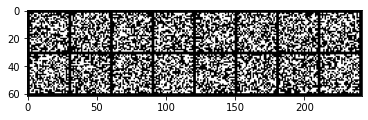

In [66]:
vk = torch.bernoulli(torch.rand(16, 28*28))
gen_plot(vk)

In [67]:
#generating images from noise
vk = vk.to(DEVICE)
for _ in range(500000):
  _, hk = rbm_model.probabilities_hidden_units(vk)
  _, vk = rbm_model.probabilities_visible_units(hk)

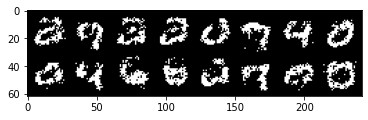

In [68]:
gen_plot(vk)